# Checkpoint 3: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones in CP2. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 29 November 2020** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [38]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last



## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [3]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

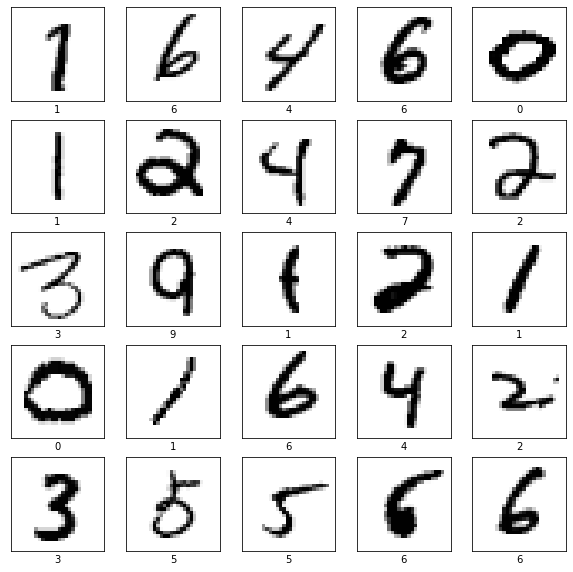

label marks [1 6 4 6 0 1 2 4 7 2 3 9 1 2 1 0 1 6 4 2 3 5 5 6 6]


In [4]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [5]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [6]:
intermediate_dim =256
latent_dim = 2

In [7]:
inputs = Input(shape=shape, name='input')
# Using convolutional and max pooling layers
x = Conv2D(1, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(2, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(x)
# Flatten, ready for dense layers
x = Flatten()(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
# Means and log(variances) layers both connected to previous dense layer
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
# Lambda layer to sample z vector from distribution given by learned means and log(variances) using 'reparameterization trick'
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 1)    10          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 1)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 2)    20          max_pooling2d[0][0]              
____________________________________________________________________________________________

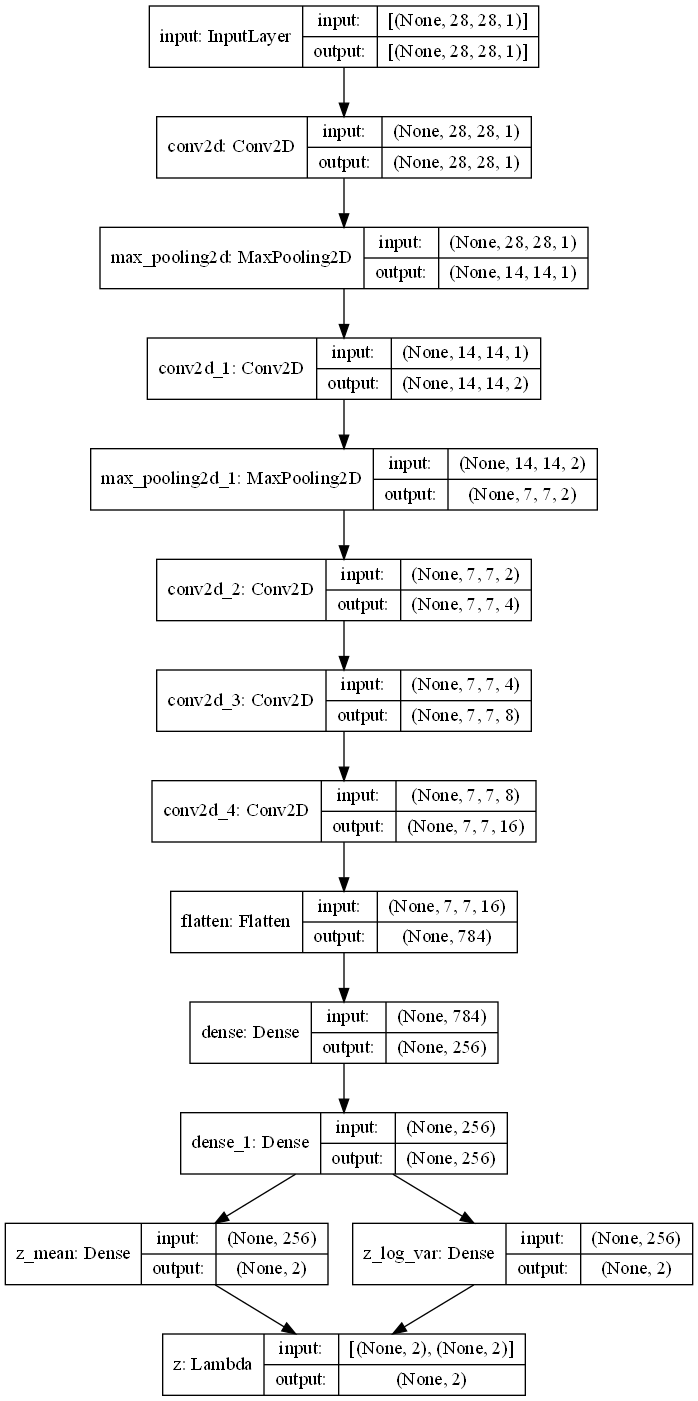

In [9]:
plot_model(encoder, show_shapes=True)

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [10]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
# Am aware instructions say use 256 again for below dense layer but made more nodes to fit with following
# Conv2DTranspose layers and instructions do also say earlier we have some freedom here
x = Dense(7*7*16, activation='relu')(x)
x = Reshape((7, 7, 16))(x)
# Conv transposes and upsampling in order to output 28x28 shaped images at the end
x = Conv2DTranspose(16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2DTranspose(8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2DTranspose(4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2DTranspose(2, kernel_size=(3,3), padding='same', activation='relu')(x)
# Sigmoid activated final layer to get pixel values in range 0 to 1
outputs = Conv2DTranspose(1, kernel_size=(3,3), padding='same', activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
# Again deviating from instructions but just went from latent vectors (ie size 2) back to 28x28 images by mirroring
# encoder convolution and pooling with conv transpose and upsampling in decoder

In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_3 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 8)         1160

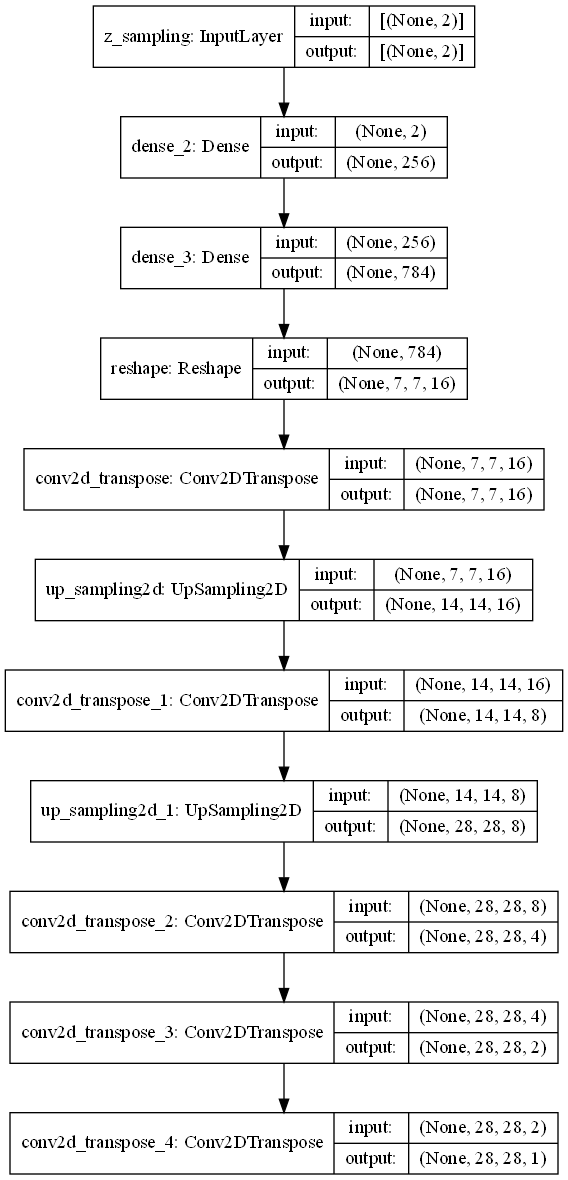

In [12]:
plot_model(decoder, show_shapes=True)

#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

In [13]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [14]:
vae = Model(i, o, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 269350    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         206121    
Total params: 475,471
Trainable params: 475,471
Non-trainable params: 0
_________________________________________________________________


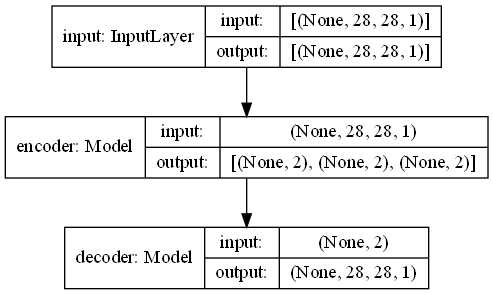

In [15]:
plot_model(vae, show_shapes=True)

Looks as expected. 28x28 greyscale images are encoded into means, log(variances) and a sample from pdf given those parameters, all lateent vectors are of length 2 as we specified 2 latent dimensions. Then sample latent vectors are decoded into 28x28 greyscale images.  

# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [16]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Call the model `vae`, and use **2 latent dimensions.**
* Display the model using the `plot_model(vae, show_shapes=True)` method, to validate that it looks as expected.
* Compile the model.
* Train for ca. **50 epochs**, using the testing dataset for validation.
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation

In [17]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

In [18]:
# Already shown diagram from `plot_model(vae, show_shapes=True)` in previous part
# Compile with given compile function to include custom VAE loss function
compile_vae(vae)
# Train for 50 epochs, 80%/20% training/validation data
vae_history = vae.fit(X_train, X_train,
                      epochs=nb_epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 69s 1ms/sample - loss: 237.1336 - reco_loss: 236.6404 - kl_loss: 0.4931 - val_loss: 197.4351 - val_reco_loss: 195.4554 - val_kl_loss: 1.9798
Epoch 2/50
48000/48000 [==============================] - 67s 1ms/sample - loss: 191.3200 - reco_loss: 189.0064 - kl_loss: 2.3135 - val_loss: 181.4797 - val_reco_loss: 177.8535 - val_kl_loss: 3.6262
Epoch 3/50
48000/48000 [==============================] - 67s 1ms/sample - loss: 174.8672 - reco_loss: 170.5960 - kl_loss: 4.2711 - val_loss: 171.4762 - val_reco_loss: 166.9615 - val_kl_loss: 4.5148
Epoch 4/50
48000/48000 [==============================] - 68s 1ms/sample - loss: 168.6367 - reco_loss: 163.9422 - kl_loss: 4.6945 - val_loss: 166.7570 - val_reco_loss: 162.2965 - val_kl_loss: 4.4605
Epoch 5/50
48000/48000 [==============================] - 68

48000/48000 [==============================] - 66s 1ms/sample - loss: 142.3691 - reco_loss: 135.8044 - kl_loss: 6.5647 - val_loss: 144.7129 - val_reco_loss: 138.3271 - val_kl_loss: 6.3858
Epoch 41/50
48000/48000 [==============================] - 66s 1ms/sample - loss: 142.4853 - reco_loss: 135.9244 - kl_loss: 6.5609 - val_loss: 143.8485 - val_reco_loss: 137.1384 - val_kl_loss: 6.7102
Epoch 42/50
48000/48000 [==============================] - 69s 1ms/sample - loss: 142.0002 - reco_loss: 135.4296 - kl_loss: 6.5706 - val_loss: 143.8941 - val_reco_loss: 137.3716 - val_kl_loss: 6.5225
Epoch 43/50
48000/48000 [==============================] - 68s 1ms/sample - loss: 142.2490 - reco_loss: 135.6659 - kl_loss: 6.5830 - val_loss: 143.8104 - val_reco_loss: 137.0988 - val_kl_loss: 6.7116
Epoch 44/50
48000/48000 [==============================] - 73s 2ms/sample - loss: 142.0158 - reco_loss: 135.4234 - kl_loss: 6.5924 - val_loss: 143.6711 - val_reco_loss: 137.1194 - val_kl_loss: 6.5517- r
Epoch 45/

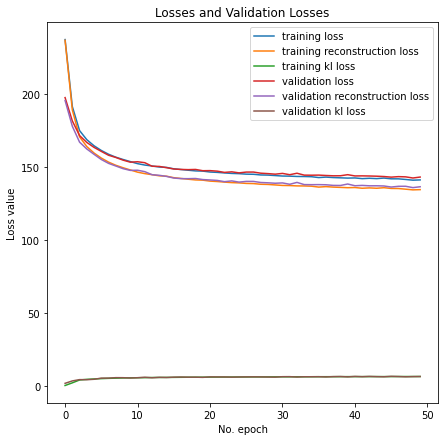

In [19]:
# Plot the two loss components and the total for both training and validation by epoch
plt.figure(figsize=(7, 7))
plt.plot(vae_history.history['loss'], label='training loss')
plt.plot(vae_history.history['reco_loss'], label='training reconstruction loss')
plt.plot(vae_history.history['kl_loss'], label='training kl loss')
plt.plot(vae_history.history['val_loss'], label='validation loss')
plt.plot(vae_history.history['val_reco_loss'], label='validation reconstruction loss')
plt.plot(vae_history.history['val_kl_loss'], label='validation kl loss')
plt.title('Losses and Validation Losses')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

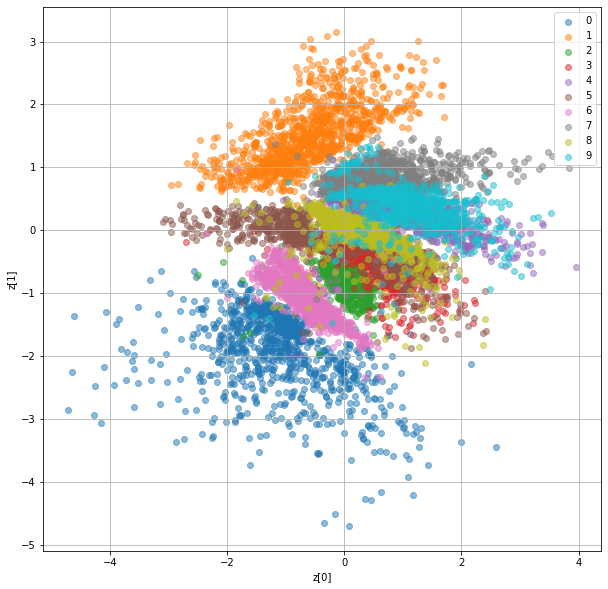

In [49]:
# Encoder outputs mean, log(var) and a sample z from pdf so took mean just for plotting but could alternatively
# plot sampled z
z_mean, _, _ = encoder.predict(X_test)

# Create figure and axis objects.
fig, ax = plt.subplots(figsize=(10,10))
# Loop for each digit label
for t in range(10):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current digit on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               single_label[:, 1],
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space for next part clear
ax.grid()
ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
plt.show()

The different coloured clusters correspond to the differently labelled digits and the VAE attempts to map these latent parameters into gaussian distribution so the clusters are packed into a mostly continuous latent space, unlike with a normal AE where encodings are all over some latent space. Clusters in the latent space that are particularly close together, or even overlap, are input digits that look similar, like 5 and 8 (you could connect the ends of a 5 and it would look like an 8) so have similarly encoded latent representations. The cluster corresponding to 1's for example is relatively separated from the rest because 1 doesn't look too similar to the other digits, closest are 9's and 7's probably because they have long 'tails' and a 1 is just a tail.

#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

In [21]:
# Size of square box in latent space
z_start = -2
z_stop = 2
# How many points per dimension
num_pts = 10

pts_line = np.linspace(z_start, z_stop, 10)
# Make separate lists of all x and y coordinates corresponding to coordinates of grid of points in box
z1s, z2s = np.meshgrid(pts_line, pts_line)
z1s = z1s.flatten()
z2s = z2s.flatten()
# zs is 
zs = np.empty([num_pts**2, 2])
# Pair up the x and y points to give list of grid coordinates
for i in range(len(z1s)):
    zs[i] = z1s[i], z2s[i]
# Reshape into square grid of coordinate pairs
z_grid = zs.reshape(num_pts, num_pts, 2)

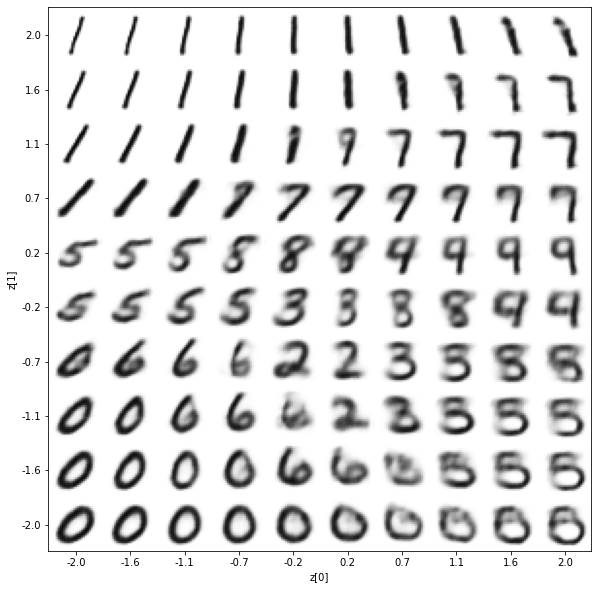

In [22]:
# Display a map of decoded digits corresponding to the points across the box in latent space
# For 28x28 images
digit_size = 28
# Create black 2D grid ready for pixel values
figure = np.zeros((digit_size * num_pts, digit_size * num_pts))

for i in range(num_pts):
    for j in range(num_pts):
        # Decode z vector
        x_decoded = decoder.predict(np.array([z_grid[num_pts-1-i][j]]))
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Place 28x28 image in place in figure grid
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
# Integer division //
# Positions of axes ticks
start_range = digit_size // 2
end_range = num_pts * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
# Labels of axes ticks
sample_range_x = np.round(pts_line, 1)
# Negative to make positive y upwards
sample_range_y = np.round(-pts_line, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap=plt.cm.binary)
plt.show()

The VAE learns the probability distribution of the latent parameters. Therefore, we can sample from this reasonably continuous distribution and generate a fictional output digit image. This is a big improvement on the normal AE which encoded the input images all across the latent space and sampling from which would give outputs that look like random noise and not a digit unless we handpicked the latent representation of one of our real input digits ie not generating any new data just reconstructing an input digit. We can see with the VAE that sampling in a 2x2 box centred on (0,0) gives us 'digit-like' images that change continuously from one type of digit to another as we move around the space. There are pockets like at (-2, -2) where, as we see in the latent space, we are drifting out of the distribution so the decoded image at (-2,-2) doesn't look so much like a digit. 

_Indicative answer:_ This figure shows us that:
        
Using VAEs, we're able to generate new images that look like the original ones. That's a pretty big thing, and something we couldn't do with a standard (non-variational) auto-encoder.


# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [23]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.python.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import Conv2DTranspose
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import Dropout
from matplotlib import pyplot
 

---

- Defined is the discriminator model using the `Sequential` keras function
    - What is the purpose of the discriminator?
    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    - Why is binary crossentropy used as the loss function?

---

1. This discriminator is a convolutional network that classifies input images. It attempts to classify real training data images and fake images generated by the generator as either real of fake. By learning how to spot fake images well, it in turn helps train the generator to generate more realistic fictional images.
1. It is structured like the CNN we have seen before: with convolutional layers, flattened and then into a dense layer. A ReLu activated layer makes any node's negative output zero instead which means information is lost and the node can 'die' meaning they are stuck outputing zero for any input and stop updating. LeakyRelu addresses this by still retaining some information by allowing small negative outputs which makes sure information is still passed to the generator. Dropout is a regularization method that means a fraction of nodes are randomly ignored during training which makes the training process more noisy and discourages overfitting.
1. Binary crossentropy is used as one data point can be assigned one of two labels (binary), real or fake, and is minimised when the predicted labels match the true labels.

In [24]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0

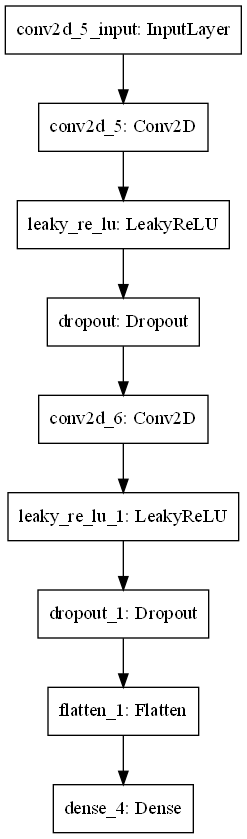

In [25]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?
    - What is the Conv2DTranspose layer used for?
    - Why is sigmoid used as the activation function?

---
1. Random noise vectors ftom the latent space are the input to the generator.
1. Conv2DTranspose layers are used to upsample from the input latent respresentation to a 28x28 output image to match the real training data.
1. Sigmoid is used on the final layer to output values between 0 and 1 just like the pixel values of the real training data.

In [26]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

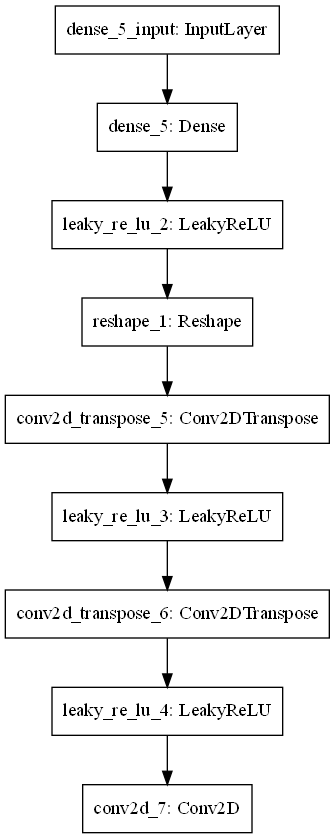

In [27]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.
    
---
1. A random latent vector is the input for the generator. This is upsampled to a 28x28 MNIST-like digit image. Then this is input to the discriminator which is a convolutional binary classifier and outputs probability that the input was a real or fake image. Therefore, is makes sense to add the generator followed by discriminator sequentially.
1. We keep the discriminator constant during the generator training. Otherwise it would be trying to hit a moving target and might never converge.

In [28]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


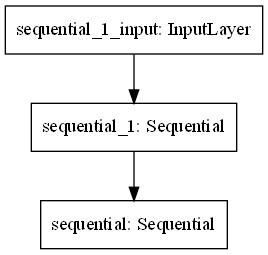

In [29]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for barch training
    - what is this data used for?
    - what is the `y = ones((n_samples, 1))` varible used for?
    
 ---
1. These real MNIST samples are mixed with the generator's fake samples to train the discriminator. The discriminator's loss on that batch is in turn used to train the generator.
1. `y = ones((n_samples, 1))` is the target column for the n real samples. These targets are all 1 because these are the real MNIST digits. The fake targets would all be 0. Again, used to calculate discriminator's loss.

In [30]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.

In [31]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

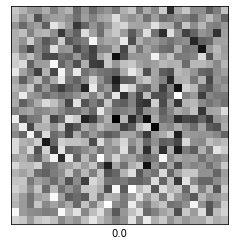

In [32]:
g_fake_sample_X, g_fake_sample_y = generate_fake_samples(g_model, latent_dim, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(g_fake_sample_X[0], cmap=plt.cm.binary)
# Label of fake sampe will be 0
plt.xlabel(g_fake_sample_y[0][0])
plt.show()

The random noise latent vector propagates through the network and although it is upsampled so the output is a 28x28 image with pixel intensities between 0 and 1, it is still just random noise and looks nothing like an MNIST digit but we shouldn't expect it to because the generator has not been trained yet.

---
Some functions for saving GAN models and output images

In [33]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context.

---
The `j` loop iterates over each batch of a single epoch. For each iteration:
- It prepares a batch of training images for the discriminator, half are real digits and half are fakes from the generator
- The discriminator is trained on just that batch and its weights are updated
- Now to update the generator we first sample some random latent vectors to serve as the generator inputs
- Set inverted labels for these as we would like the incentivise the generator to make images that are classified as real (1's) after propagating through the entire GAN (ie fooling the discriminator)
- The generator weights are updated based on how succesfully its images generated from the latent samples fooled the discriminator (ie the discriminator's error)
- The separate loss details for the discriminator and generator from this batch are printed

So for each batch in the epoch, the discriminator and generator weights are updated separately and not both simultaneously. This is repeeated for a specified number of epochs.

In [34]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

In [35]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=3)

>1, 1/234, d=0.689, g=0.764
>1, 2/234, d=0.686, g=0.781
>1, 3/234, d=0.670, g=0.802
>1, 4/234, d=0.665, g=0.821
>1, 5/234, d=0.659, g=0.840
>1, 6/234, d=0.654, g=0.857
>1, 7/234, d=0.648, g=0.868
>1, 8/234, d=0.643, g=0.871
>1, 9/234, d=0.639, g=0.867
>1, 10/234, d=0.640, g=0.865
>1, 11/234, d=0.641, g=0.847
>1, 12/234, d=0.645, g=0.819
>1, 13/234, d=0.654, g=0.793
>1, 14/234, d=0.658, g=0.765
>1, 15/234, d=0.658, g=0.744
>1, 16/234, d=0.656, g=0.730
>1, 17/234, d=0.651, g=0.717
>1, 18/234, d=0.644, g=0.709
>1, 19/234, d=0.639, g=0.705
>1, 20/234, d=0.632, g=0.701
>1, 21/234, d=0.626, g=0.699
>1, 22/234, d=0.615, g=0.698
>1, 23/234, d=0.607, g=0.697
>1, 24/234, d=0.597, g=0.697
>1, 25/234, d=0.588, g=0.698
>1, 26/234, d=0.574, g=0.697
>1, 27/234, d=0.561, g=0.698
>1, 28/234, d=0.552, g=0.699
>1, 29/234, d=0.542, g=0.700
>1, 30/234, d=0.528, g=0.701
>1, 31/234, d=0.523, g=0.703
>1, 32/234, d=0.505, g=0.704
>1, 33/234, d=0.487, g=0.706
>1, 34/234, d=0.485, g=0.707
>1, 35/234, d=0.478, g=

>2, 40/234, d=0.045, g=3.073
>2, 41/234, d=0.045, g=3.075
>2, 42/234, d=0.037, g=3.081
>2, 43/234, d=0.044, g=3.136
>2, 44/234, d=0.035, g=3.157
>2, 45/234, d=0.051, g=3.141
>2, 46/234, d=0.043, g=3.156
>2, 47/234, d=0.038, g=3.156
>2, 48/234, d=0.041, g=3.159
>2, 49/234, d=0.046, g=3.161
>2, 50/234, d=0.038, g=3.198
>2, 51/234, d=0.036, g=3.174
>2, 52/234, d=0.036, g=3.215
>2, 53/234, d=0.040, g=3.224
>2, 54/234, d=0.035, g=3.235
>2, 55/234, d=0.048, g=3.230
>2, 56/234, d=0.034, g=3.255
>2, 57/234, d=0.038, g=3.248
>2, 58/234, d=0.043, g=3.269
>2, 59/234, d=0.037, g=3.273
>2, 60/234, d=0.035, g=3.282
>2, 61/234, d=0.033, g=3.292
>2, 62/234, d=0.036, g=3.282
>2, 63/234, d=0.037, g=3.301
>2, 64/234, d=0.048, g=3.295
>2, 65/234, d=0.046, g=3.277
>2, 66/234, d=0.034, g=3.320
>2, 67/234, d=0.035, g=3.331
>2, 68/234, d=0.026, g=3.360
>2, 69/234, d=0.033, g=3.358
>2, 70/234, d=0.034, g=3.370
>2, 71/234, d=0.031, g=3.382
>2, 72/234, d=0.025, g=3.403
>2, 73/234, d=0.028, g=3.405
>2, 74/234, d=

>3, 84/234, d=0.685, g=0.738
>3, 85/234, d=0.680, g=0.702
>3, 86/234, d=0.694, g=0.716
>3, 87/234, d=0.697, g=0.725
>3, 88/234, d=0.708, g=0.748
>3, 89/234, d=0.678, g=0.725
>3, 90/234, d=0.704, g=0.744
>3, 91/234, d=0.685, g=0.745
>3, 92/234, d=0.693, g=0.732
>3, 93/234, d=0.673, g=0.709
>3, 94/234, d=0.675, g=0.740
>3, 95/234, d=0.699, g=0.732
>3, 96/234, d=0.683, g=0.744
>3, 97/234, d=0.667, g=0.760
>3, 98/234, d=0.668, g=0.746
>3, 99/234, d=0.674, g=0.746
>3, 100/234, d=0.705, g=0.753
>3, 101/234, d=0.686, g=0.752
>3, 102/234, d=0.682, g=0.761
>3, 103/234, d=0.676, g=0.761
>3, 104/234, d=0.651, g=0.789
>3, 105/234, d=0.684, g=0.773
>3, 106/234, d=0.683, g=0.787
>3, 107/234, d=0.678, g=0.757
>3, 108/234, d=0.660, g=0.764
>3, 109/234, d=0.663, g=0.810
>3, 110/234, d=0.678, g=0.767
>3, 111/234, d=0.698, g=0.793
>3, 112/234, d=0.663, g=0.798
>3, 113/234, d=0.679, g=0.799
>3, 114/234, d=0.686, g=0.799
>3, 115/234, d=0.672, g=0.784
>3, 116/234, d=0.678, g=0.805
>3, 117/234, d=0.665, g=0.

There is tradeoff and a lot of back-and-forth in the loss functions against time. This is expected because as the generator makes more realistic images, the discriminator has a harder time classifying them from the real images, so its loss rises, but as the discriminator improves, the generator's images fail to fool it more often, so its loss rises. Running for enough epochs to get the best generator loss would mean its images are indistinguishable from the real digits, the discriminator will just have to 50/50 guess at real of fake. But we are far from that after just three epochs.

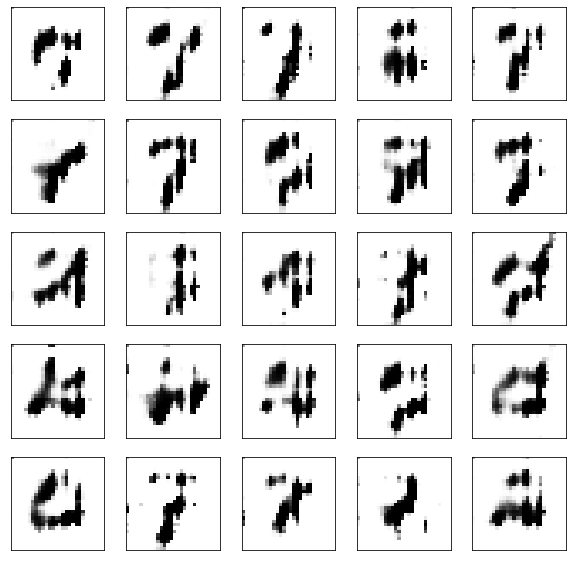

In [37]:
# Same way of plotting as before
n_plots = 25
g_fake_samples, _ = generate_fake_samples(g_model, latent_dim, n_plots)
plt.figure(figsize=(10,10))
for i in range(n_plots):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(g_fake_samples[i], cmap=plt.cm.binary)
plt.show()

After three epochs we are generating images that are a lot better than the noise from before but far from clear digits.